![image.png](attachment:image.png)

## PRACTICA OBLIGATORIA: **Transfer Learning y Fine Tuning**

* La práctica obligatoria de esta unidad consiste en un repetir el ejercicio de construcción de un modelo de clasificación de paisajes pero usando un modelo preentrenado. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo.
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso.

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [ ]:
import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns


from skimage.io import imread
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from time import time

import gc # garbage collection


In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.test.gpu_device_name())

Num GPUs Available:  1
/device:GPU:0


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("puneet6060/intel-image-classification")

print("Path to dataset files:", path)

100%|██████████| 346M/346M [00:01<00:00, 221MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/puneet6060/intel-image-classification/versions/2


### Objetivo del ejercicio

Comparar una red convolucional hecha ad-hoc frente a los modelos preentrenados y ajustados con fine tuning y transfer learning. Para ello emplea el dataset de paisajes del conjunto de ejercicios de la unidad anterior.


### Se pide

1. Preparar los datos del modelo y las funciones de visualización, copia para ello todo lo que necesites de las soluciones del ejercicio de clasificación de paisajes de la unidad anterior.

2. Escoger entre uno de los modelos VGG-19, InceptionV3 y MobileNetV2 (todos en https://keras.io/api/applications/) (Se aconseja este último si no tenemos un ordenador muy potente). Si no te haces con estos puedes recurrir a la ResNetV50.

4. Hacer un transfer-learning con una cabeza de como mucho 2 capas densas ocultas y una de salida. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

5. Hacer un fine-tuning con la misma cabeza diseñada en el punto anterior. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

6. Comparar los resultados con los obtenidos con la red convolucional del ejercicio mencionado.

EXTRA:
- Repetir el transfer learning empleando aumentado de imágenes.



### Funciones y preparación de datos (código replicado de la solución del ejercicio de la primera unidad)

In [ ]:
ROOT_PATH = path

In [ ]:
### Carga de datos y preparación obtenidas del ejercicio de la unidad 1:
# ROOT_PATH = './data/'
TRAIN_PATH = ROOT_PATH + "/seg_train/seg_train/"
TEST_PATH = ROOT_PATH + "/seg_test/seg_test/"


In [ ]:
os.listdir(TRAIN_PATH)

['glacier', 'sea', 'mountain', 'buildings', 'forest', 'street']

In [ ]:
os.listdir(TEST_PATH)

['glacier', 'sea', 'mountain', 'buildings', 'forest', 'street']

*Introducimos un parametro de control de la resolución, según las dimensiones de entrada de nuestra red, pero que podamos tocar sin cambiar nada del resto del código para poder probar otras resoluciones*

In [ ]:
IMG_WIDTH = IMG_HEIGHT = 75

In [ ]:
def read_data(directorio, reshape_dim = (IMG_WIDTH,IMG_HEIGHT)):
    X = []
    y = []
    for folder in os.listdir(directorio):
        print(folder)
        if os.path.isdir('/'.join([directorio, folder])):
            for file in os.listdir('/'.join([directorio, folder])):

                image = imread('/'.join([directorio, folder, file]))
                image = cv2.resize(image, reshape_dim) # Redimensionamos las imágenes a 75x75

                X.append(image)
                y.append(folder)

    return np.array(X),np.array(y)

def show_images_batch(paisajes, names = [], n_cols = 5, size_scale = 2):
    n_rows = ((len(paisajes) - 1) // n_cols + 1)
    plt.figure(figsize=(n_cols * size_scale, n_rows * 1.1*size_scale))
    for index, paisaje in enumerate(paisajes):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(paisaje, cmap = "Greys")
        plt.axis("off")
        if len(names):
            plt.title(names[index])


In [ ]:
X_train, y_train = read_data(TRAIN_PATH)
X_test, y_test = read_data(TEST_PATH)

glacier
sea
mountain
buildings
forest
street
glacier
sea
mountain
buildings
forest
street


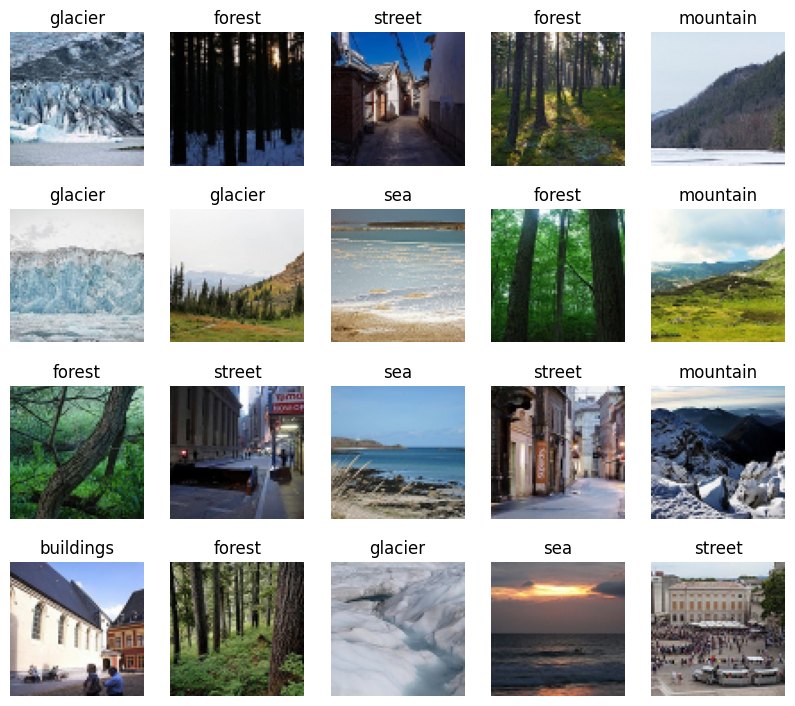

In [ ]:
indices = np.random.randint(0,len(X_train),20)
show_images_batch(X_train[indices], names = y_train[indices], n_cols = 5)

In [ ]:
X_train.shape

(14034, 75, 75, 3)

In [ ]:
X_train.size

236823750

In [ ]:
X_test.shape

(3000, 75, 75, 3)

Escalamos

In [ ]:
X_train = X_train/255
X_test = X_test/255

In [ ]:
# np.savez(ROOT_PATH + 'data.npz', X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

In [ ]:
# data = np.load(ROOT_PATH + 'data.npz')

# X_train = data['X_train']
# X_test = data['X_test']
# y_train = data['y_train']
# y_test = data['y_test']

### Seleccion del modelo a transferir y tunear


*Escogemos el modelo de [Inception V3](https://arxiv.org/abs/1512.00567) el que tiene las supercapas convolucionales para hacer transfer learning*

In [ ]:
from keras.applications import InceptionV3

*Si investigas en la documentación del modelo verás que no puede admite resoluciones de entrada inferiores a 75x75*

### Transfer Learning

*Para el transfer learning vamos a usar una cabeza con una única capa densa con tantas unidades como el aplanamiento de las imagenes, es decir dependiendo de la resolución con la que hayamos cargado las imágenes al principio así tendremos una cantidad u otra de unidades*

In [ ]:
X_train.size

236823750

*El train tiene un tamaño más que considerable para aplicar un Adam y eso vamos a hacer, en principio sin tocar nada más*

In [ ]:
test_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

In [ ]:
test_model.input

<KerasTensor shape=(None, 75, 75, 3), dtype=float32, sparse=False, name=keras_tensor_311>

In [ ]:
test_model.output_shape

(None, 1, 1, 2048)

In [ ]:
del test_model
gc.collect()

0

In [ ]:
IMG_WIDTH = IMG_HEIGHT = 75
# Cargamos el modelo pre-entrenado
base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

# Congelamos sus capas
for layer in base_model.layers:
    layer.trainable = False

# Capa de aplanado de la salida del modelo base
def prepare_model(base_model = base_model): # Lo creamos así para poder reinicializarlo en cada reentrenamiento en ejercicios posteriores

    x = keras.layers.Flatten()(base_model.output)

    # Tantas unidades como el flatten de la salida de Inception -> 2048 features
    x = keras.layers.Dense(2048, activation='relu')(x)
    x = keras.layers.Dropout(rate = 0.25)(x)

    # Capa final de salida con 6 neuronas (una por clase) y activación softmax
    x = keras.layers.Dense(6, activation='softmax')(x)

    model = keras.Model(base_model.input, x)

    model.compile(
        optimizer = "adam",
        loss = 'sparse_categorical_crossentropy', # sparse -> y es un array de escalares pero hay varias categorias, y un array de vectores
        metrics = ['acc']
        )

    return model

# Observamos la arquitectura del modelo
model= prepare_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 75, 75, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_188 (Conv2D)       │ (None, 37, 37, 32)     │            864 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_188   │ (None, 37, 37, 32)     │             96 │ conv2d_188[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_188            │ (None, 37, 37, 32)     │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_189 (Conv2D)       │ (None, 35, 35, 32)     │          9,216 │ activation_188[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_189   │ (None, 35, 35, 32)     │             96 │ conv2d_189[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_189            │ (None, 35, 35, 32)     │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_190 (Conv2D)       │ (None, 35, 35, 64)     │         18,432 │ activation_189[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_190   │ (None, 35, 35, 64)     │            192 │ conv2d_190[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_190            │ (None, 35, 35, 64)     │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_8           │ (None, 17, 17, 64)     │              0 │ activation_190[0][0]   │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_191 (Conv2D)       │ (None, 17, 17, 80)     │          5,120 │ max_pooling2d_8[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_191   │ (None, 17, 17, 80)     │            240 │ conv2d_191[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_191            │ (None, 17, 17, 80)     │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_192 (Conv2D)  

 Total params: 26,011,430 (99.23 MB)

 Trainable params: 4,208,646 (16.05 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

*Ahora vamos a configurar el resto de hiperparámetros, el batch_size, el número de épocas y el EarlyStopping*

In [ ]:
instancias_train = len(X_train)

for i in range(1,5):
    print(f"Batch_size: {32*i}, num_steps_per_epoch: {round(instancias_train/(32*i))}")

Batch_size: 32, num_steps_per_epoch: 439
Batch_size: 64, num_steps_per_epoch: 219
Batch_size: 96, num_steps_per_epoch: 146
Batch_size: 128, num_steps_per_epoch: 110


*Podemos atrevernos hasta con batches de 128, para saber cuál usar vamos a hacer un entrenamiento de una época con cada uno y ver tiempos*

*Antes tendremos que convertir las etiquetas a números*

In [ ]:
y_train

array(['glacier', 'glacier', 'glacier', ..., 'street', 'street', 'street'],
      dtype='<U9')

In [ ]:
targets = pd.Series(y_train)

In [ ]:
mapa = {tipo:indice for indice,tipo in enumerate(targets.unique())} # Reutilizando la serie que creamos para ver la distribución del target
mapa

{'glacier': 0,
 'sea': 1,
 'mountain': 2,
 'buildings': 3,
 'forest': 4,
 'street': 5}

In [ ]:
y_train_num = np.array([mapa[y] for y in y_train])
y_test_num = np.array([mapa[y] for y in y_test])

In [ ]:
y_train_num

array([0, 0, 0, ..., 5, 5, 5])

In [ ]:
from sklearn.utils import shuffle
X_train_s,y_train_s = shuffle(X_train, y_train_num)

In [ ]:
from time import time

for batch_size in [32,64,96,128]:
    t_zero = time()
    model = prepare_model()
    model.fit(X_train,
              y_train_num,
              batch_size = batch_size,
              validation_split=0.2,
              epochs=1)
    tiempo = round(time() - t_zero, 3)
    del model
    gc.collect()
    print(f"batch_size: {batch_size}, num_steps: {len(X_train)/batch_size}, tiempo 1 epoca: {tiempo}, tiempo 20 épocas: {tiempo * 20}")


351/351 ━━━━━━━━━━━━━━━━━━━━ 41s 72ms/step - acc: 0.6933 - loss: 0.8603 - val_acc: 0.1364 - val_loss: 11.2000
batch_size: 32, num_steps: 438.5625, tiempo 1 epoca: 44.391, tiempo 20 épocas: 887.8199999999999
176/176 ━━━━━━━━━━━━━━━━━━━━ 36s 118ms/step - acc: 0.6851 - loss: 0.8684 - val_acc: 0.1393 - val_loss: 10.7121
batch_size: 64, num_steps: 219.28125, tiempo 1 epoca: 51.015, tiempo 20 épocas: 1020.3
117/117 ━━━━━━━━━━━━━━━━━━━━ 37s 181ms/step - acc: 0.6570 - loss: 0.9919 - val_acc: 0.1325 - val_loss: 11.0756
batch_size: 96, num_steps: 146.1875, tiempo 1 epoca: 40.107, tiempo 20 épocas: 802.14
88/88 ━━━━━━━━━━━━━━━━━━━━ 36s 238ms/step - acc: 0.6294 - loss: 0.9888 - val_acc: 0.1404 - val_loss: 11.1367
batch_size: 128, num_steps: 109.640625, tiempo 1 epoca: 38.438, tiempo 20 épocas: 768.76


*Vamos a por los 128 de batch size*

In [ ]:
batch_size = 128

In [ ]:
earlyS = keras.callbacks.EarlyStopping(patience= 10, restore_best_weights= True)

In [ ]:
t_zero = time()
model = prepare_model()
history = model.fit(X_train_s,
                    y_train_s,
                    batch_size = batch_size,
                    validation_split=0.2,
                    epochs=40,
                    callbacks = [earlyS])
tiempo = round(time() - t_zero, 3)

Epoch 1/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 34s 238ms/step - acc: 0.6360 - loss: 1.0364 - val_acc: 0.7677 - val_loss: 0.6269
Epoch 2/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - acc: 0.8227 - loss: 0.4825 - val_acc: 0.7567 - val_loss: 0.6561
Epoch 3/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - acc: 0.8778 - loss: 0.3497 - val_acc: 0.7766 - val_loss: 0.5989
Epoch 4/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - acc: 0.9203 - loss: 0.2432 - val_acc: 0.7727 - val_loss: 0.6352
Epoch 5/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - acc: 0.9544 - loss: 0.1600 - val_acc: 0.7627 - val_loss: 0.7202
Epoch 6/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - acc: 0.9745 - loss: 0.1040 - val_acc: 0.7602 - val_loss: 0.7396
Epoch 7/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - acc: 0.9864 - loss: 0.0736 - val_acc: 0.7702 - val_loss: 0.7820
Epoch 8/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - acc: 0.9937 - loss: 0.0421 - val_acc: 0.7638 - val_loss: 0.8210
Epoch 9/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - acc: 0.9

*Evaluamos*

In [ ]:
model.evaluate(X_test,y_test_num)

94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - acc: 0.7323 - loss: 0.7584


[0.6087880730628967, 0.7876666784286499]

*Un 78% que es un 2% mejor que la convolucional "sencilla", no es mucha ganancia para tanto armatoste. ¿Podríamos mejorar la cabeza decisora?*

*Completemos con el análisis del informe de clasificación y de la matriz de confusión*

In [ ]:
y_pred = [np.argmax(prediction) for prediction in model.predict(X_test)]

94/94 ━━━━━━━━━━━━━━━━━━━━ 14s 76ms/step


In [ ]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
inverse_map = {valor:clave for clave,valor in mapa.items()}
y_test_labels = [inverse_map[y] for y in y_test_num]
y_pred_labels = [inverse_map[y] for y in y_pred]
print(classification_report(y_test_labels, y_pred_labels))

              precision    recall  f1-score   support

   buildings       0.83      0.81      0.82       437
      forest       0.94      0.95      0.95       474
     glacier       0.73      0.67      0.70       553
    mountain       0.67      0.73      0.70       525
         sea       0.75      0.78      0.77       510
      street       0.83      0.81      0.82       501

    accuracy                           0.79      3000
   macro avg       0.79      0.79      0.79      3000
weighted avg       0.79      0.79      0.79      3000



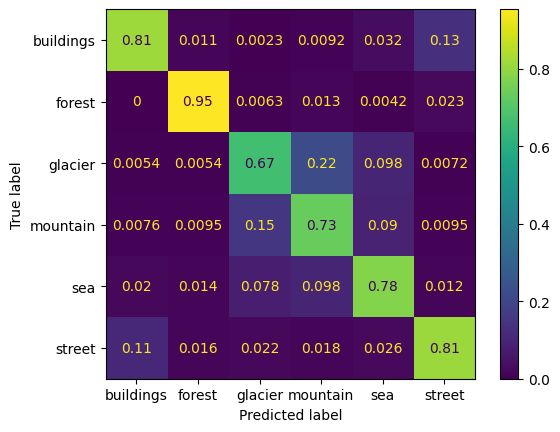

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test_labels, y_pred_labels, normalize="true")
plt.show()

*Confunde montañas con glaciares y viceversa (las clases peor paradas), aunque también confunde el mar tanto con glaciar como con montaña. Es peor en montañas que el clasificador del ejercicio pero sensiblemente mejor en edificios y en glaciares (las dos clases "malas" del clasificador de los ejercicios). Al igual que el clasificador del ejercicio confunde calles con edificios.*

In [ ]:
del model
del history
gc.collect()

### Fine-Tuning

*Mantenemos la Inception V3**

In [ ]:
# Cargamos el modelo pre-entrenado
base_model = InceptionV3(include_top=False, weights=None, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

# # Congelamos sus capas
# for layer in base_model.layers:
#    layer.trainable = False

# Capa de flatenizado de la salida del modelo base
def prepare_model(base_model = base_model): # Lo creamos así para poder reinicializarlo en cada reentrenamiento en ejercicios posteriores
    x = keras.layers.Flatten()(base_model.output)

    # Tantas unidades como el flatten de la salida de Inception
    x = keras.layers.Dense(2048, activation='relu')(x)
    x = keras.layers.Dropout(rate = 0.25)(x)

    # Capa final de salida con 6 neuronas (una por clase) y activación softmax
    x = keras.layers.Dense(6, activation='softmax')(x)

    model = keras.Model(base_model.input, x)

    model.compile(
        optimizer = "adam",
        loss = 'sparse_categorical_crossentropy',
        metrics = ['acc'])

    return model

# Observamos la arquitectura del modelo
model= prepare_model()
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 75, 75, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_282 (Conv2D)       │ (None, 37, 37, 32)     │            864 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_282   │ (None, 37, 37, 32)     │             96 │ conv2d_282[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_282            │ (None, 37, 37, 32)     │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_283 (Conv2D)       │ (None, 35, 35, 32)     │          9,216 │ activation_282[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_283   │ (None, 35, 35, 32)     │             96 │ conv2d_283[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_283            │ (None, 35, 35, 32)     │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_284 (Conv2D)       │ (None, 35, 35, 64)     │         18,432 │ activation_283[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_284   │ (None, 35, 35, 64)     │            192 │ conv2d_284[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_284            │ (None, 35, 35, 64)     │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_12          │ (None, 17, 17, 64)     │              0 │ activation_284[0][0]   │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_285 (Conv2D)       │ (None, 17, 17, 80)     │          5,120 │ max_pooling2d_12[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_285   │ (None, 17, 17, 80)     │            240 │ conv2d_285[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_285            │ (None, 17, 17, 80)     │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_286 (Conv2D)  

 Total params: 26,011,430 (99.23 MB)

 Trainable params: 25,976,998 (99.09 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [ ]:
from time import time

for batch_size in [32,64,96,128]:
    t_zero = time()
    model = prepare_model()
    model.fit(X_train_s,
              y_train_s,
              batch_size = batch_size,
              validation_split=0.2,
              epochs=1)
    tiempo = round(time() - t_zero, 3)
    del model
    gc.collect()
    print(f"batch_size: {batch_size}, num_steps: {len(X_train)/batch_size}, tiempo 1 epoca: {tiempo}, tiempo 20 épocas: {tiempo * 20}")

351/351 ━━━━━━━━━━━━━━━━━━━━ 139s 188ms/step - acc: 0.4286 - loss: 1.9122 - val_acc: 0.2839 - val_loss: 2.4759
batch_size: 32, num_steps: 438.5625, tiempo 1 epoca: 141.793, tiempo 20 épocas: 2835.86
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - acc: 0.4866 - loss: 1.4308

*Mantenemos el batch_size en 128*

*Lanzamos el fine-tuning y a esperar*

In [ ]:
t_zero = time()
model = prepare_model()
history = model.fit(X_train_s,
                    y_train_s,
                    batch_size = batch_size,
                    validation_split=0.2,
                    epochs=40,
                    callbacks = [earlyS])
tiempo = round(time() - t_zero, 3)

Epoch 1/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 132s 676ms/step - acc: 0.3937 - loss: 2.1288 - val_acc: 0.1585 - val_loss: 2.2350
Epoch 2/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 57s 107ms/step - acc: 0.6826 - loss: 0.8759 - val_acc: 0.1585 - val_loss: 2.5689
Epoch 3/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - acc: 0.7622 - loss: 0.6802 - val_acc: 0.1678 - val_loss: 3.3595
Epoch 4/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - acc: 0.8021 - loss: 0.5646 - val_acc: 0.3003 - val_loss: 2.7266
Epoch 5/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 11s 112ms/step - acc: 0.8278 - loss: 0.5104 - val_acc: 0.4717 - val_loss: 2.3465
Epoch 6/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - acc: 0.8468 - loss: 0.4604 - val_acc: 0.6958 - val_loss: 1.1843
Epoch 7/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - acc: 0.8638 - loss: 0.3950 - val_acc: 0.6708 - val_loss: 1.2217
Epoch 8/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - acc: 0.8884 - loss: 0.3379 - val_acc: 0.7243 - val_loss: 1.1024
Epoch 9/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/

In [ ]:
model.evaluate(X_test,y_test_num)

94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - acc: 0.8191 - loss: 0.6124


[0.6847866177558899, 0.7996666431427002]

*Bueno, un 80%, 4 pp. mejor que el modelo con dos capas convolucionales,... ¿merece la pena el esfuerzo?*

In [ ]:
y_pred = [ np.argmax(prediction) for prediction in model.predict(X_test)]

94/94 ━━━━━━━━━━━━━━━━━━━━ 13s 73ms/step


In [ ]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
inverse_map = {valor:clave for clave,valor in mapa.items()}
y_test_labels = [inverse_map[y] for y in y_test_num]
y_pred_labels = [inverse_map[y] for y in y_pred]
print(classification_report(y_test_labels, y_pred_labels))

              precision    recall  f1-score   support

   buildings       0.78      0.75      0.76       437
      forest       0.95      0.88      0.91       474
     glacier       0.87      0.62      0.73       553
    mountain       0.73      0.85      0.79       525
         sea       0.77      0.86      0.81       510
      street       0.76      0.84      0.80       501

    accuracy                           0.80      3000
   macro avg       0.81      0.80      0.80      3000
weighted avg       0.81      0.80      0.80      3000



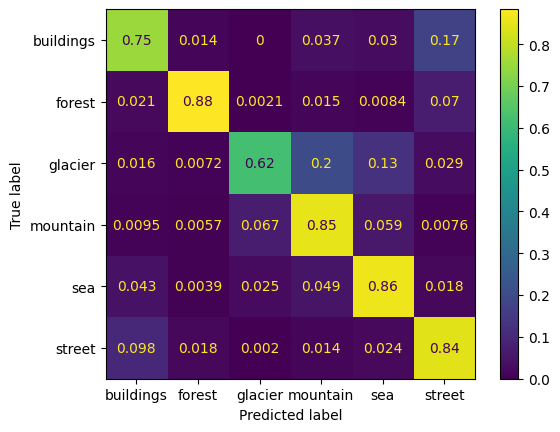

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test_labels, y_pred_labels, normalize="true")
plt.show()

*El modelo completo ha mejorado en las que era peor el anterior pero a costa de empeorar en edificios y calles que ahora se confunden no solo entre ellos sino que un poco con todos.*

*El modelo fine-tuneado mejora en casi todo al modelo inicial, salvo en la detección de street y ligeramente en las montañas*

### EXTRA

*Vamos a repetir la parte de transfer learning pero utilizando "aumentado de imágenes" a ver si mejoramos algo más*

In [ ]:
ficheros = []
clases = []
for directorio in os.listdir(TRAIN_PATH):
    clase = directorio
    ficher = [TRAIN_PATH + directorio + "/" + fichero for fichero in os.listdir(TRAIN_PATH + directorio)]
    clases += [clase for fichero in ficher]
    ficheros += ficher
train_augmented = pd.DataFrame({"filename": ficheros,"category": clases})
train_augmented.head(10)

,filename,category
0,/root/.cache/kagglehub/datasets/puneet6060/int...,street
1,/root/.cache/kagglehub/datasets/puneet6060/int...,street
2,/root/.cache/kagglehub/datasets/puneet6060/int...,street
3,/root/.cache/kagglehub/datasets/puneet6060/int...,street
4,/root/.cache/kagglehub/datasets/puneet6060/int...,street
5,/root/.cache/kagglehub/datasets/puneet6060/int...,street
6,/root/.cache/kagglehub/datasets/puneet6060/int...,street
7,/root/.cache/kagglehub/datasets/puneet6060/int...,street
8,/root/.cache/kagglehub/datasets/puneet6060/int...,street
9,/root/.cache/kagglehub/datasets/puneet6060/int...,street


In [ ]:
# def prep_fn(img):
#   img = img.astype(np.float32) / 255.0
#   img = (img - 0.5) * 2
#   return img

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    # preprocessing_function=prep_fn,
    rotation_range=15, # Angulo de rotación
    rescale=1./255, # Escalado
    shear_range=0.1, # Inclina las imágenes, no es giro es inclinación como hacerlas "cursivas"
    zoom_range=0.2, # Zoom
    horizontal_flip=True, # giro horizontal o especular
    width_shift_range=0.1, # Desplazamiento horizontal de los pixeles
    height_shift_range=0.1 # Desplazamiento vertical de los píxeles
)

In [ ]:
train_df, validate_df = train_test_split(train_augmented,
                                         test_size=0.20,
                                         stratify=train_augmented['category'],
                                         random_state=42)

In [ ]:
train_df.head()

,filename,category
5803,/root/.cache/kagglehub/datasets/puneet6060/int...,buildings
8811,/root/.cache/kagglehub/datasets/puneet6060/int...,sea
10109,/root/.cache/kagglehub/datasets/puneet6060/int...,glacier
10275,/root/.cache/kagglehub/datasets/puneet6060/int...,glacier
11834,/root/.cache/kagglehub/datasets/puneet6060/int...,forest


In [ ]:
validate_df.head()

,filename,category
12959,/root/.cache/kagglehub/datasets/puneet6060/int...,forest
11187,/root/.cache/kagglehub/datasets/puneet6060/int...,glacier
4178,/root/.cache/kagglehub/datasets/puneet6060/int...,mountain
5273,/root/.cache/kagglehub/datasets/puneet6060/int...,buildings
6845,/root/.cache/kagglehub/datasets/puneet6060/int...,buildings


In [ ]:
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [ ]:
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='category',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    class_mode='sparse', # Porque es multiclase (otras configuraciones, ver la documentación)
    batch_size= batch_size
)

Found 11227 validated image filenames belonging to 6 classes.


In [ ]:
validation_datagen = ImageDataGenerator(rescale=1./255) # Solo vamos a reescalar

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    x_col='filename',
    y_col='category',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    class_mode='sparse',
    batch_size= batch_size
)

Found 2807 validated image filenames belonging to 6 classes.


In [ ]:
from keras.applications import InceptionV3

# Cargamos el modelo pre-entrenado
base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

# Congelamos sus capas
for layer in base_model.layers:
    layer.trainable = False

# Capa de flatenizado de la salida del modelo base
def prepare_model(base_model = base_model): # Lo creamos así para poder reinicializarlo en cada reentrenamiento en ejercicios posteriores
    x = keras.layers.Flatten()(base_model.output)

    # Tantas unidades como el flatten de la salida de Inception
    x = keras.layers.Dense(2048, activation='relu')(x)
    x = keras.layers.Dropout(rate = 0.25)(x)

    # Capa final de salida con 6 neuronas (una por clase) y activación softmax
    x = keras.layers.Dense(6, activation='softmax')(x)

    model = keras.Model(base_model.input, x)

    model.compile(
        optimizer = "adam",
        loss = 'sparse_categorical_crossentropy',
        metrics = ['acc']
        )

    return model

In [ ]:
model = prepare_model()
history = model.fit(
    train_generator,
    epochs= 40,
    validation_data=validation_generator,
    callbacks= earlyS
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - acc: 0.5581 - loss: 1.2298

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


88/88 ━━━━━━━━━━━━━━━━━━━━ 56s 475ms/step - acc: 0.5592 - loss: 1.2267 - val_acc: 0.7567 - val_loss: 0.6786
Epoch 2/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 29s 330ms/step - acc: 0.7394 - loss: 0.7248 - val_acc: 0.7613 - val_loss: 0.6467
Epoch 3/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 29s 330ms/step - acc: 0.7396 - loss: 0.6871 - val_acc: 0.7681 - val_loss: 0.6200
Epoch 4/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 30s 338ms/step - acc: 0.7614 - loss: 0.6491 - val_acc: 0.7748 - val_loss: 0.6121
Epoch 5/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 28s 321ms/step - acc: 0.7554 - loss: 0.6451 - val_acc: 0.7724 - val_loss: 0.6061
Epoch 6/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 31s 349ms/step - acc: 0.7531 - loss: 0.6427 - val_acc: 0.7716 - val_loss: 0.6035
Epoch 7/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 28s 322ms/step - acc: 0.7716 - loss: 0.6093 - val_acc: 0.7887 - val_loss: 0.5665
Epoch 8/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 30s 339ms/step - acc: 0.7736 - loss: 0.5953 - val_acc: 0.7873 - val_loss: 0.5758
Epoch 9/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 28s 324ms/step - acc:

In [ ]:
model.evaluate(X_test,y_test_num)

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - acc: 0.0647 - loss: 4.8919


[5.18716287612915, 0.06199999898672104]

Quéeeee??? Que nuestra red contra Train va bien, contra Validation también y contra Test tenemos un 6% de accuracy ¿?¿?¿?

Un momento...

In [ ]:
validation_generator.class_indices

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [ ]:
mapa

{'street': 0,
 'mountain': 1,
 'buildings': 2,
 'sea': 3,
 'glacier': 4,
 'forest': 5}

Vaya, vaya, así que el mapa que habíamos usado al principio es diferente a los indices que produce el generador en orden alfabético. Vamos a corregir nuestro `y_test_num` a ver qué tal

In [ ]:
y_test_num = np.array([validation_generator.class_indices[y] for y in y_test])

In [ ]:
model.evaluate(X_test,y_test_num)

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - acc: 0.7771 - loss: 0.5997


[0.5722430944442749, 0.7799999713897705]

Mucho mejor, ahoro sí tiene sentido el resultado.

In [ ]:
y_pred = [ np.argmax(prediction) for prediction in model.predict(X_test)]

94/94 ━━━━━━━━━━━━━━━━━━━━ 15s 77ms/step


In [ ]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
inverse_map = {valor:clave for clave,valor in validation_generator.class_indices.items()}
y_test_labels = [inverse_map[y] for y in y_test_num]
y_pred_labels = [inverse_map[y] for y in y_pred]
print(classification_report(y_test_labels, y_pred_labels))

              precision    recall  f1-score   support

   buildings       0.82      0.84      0.83       437
      forest       0.94      0.92      0.93       474
     glacier       0.72      0.67      0.69       553
    mountain       0.69      0.65      0.67       525
         sea       0.70      0.82      0.75       510
      street       0.84      0.82      0.83       501

    accuracy                           0.78      3000
   macro avg       0.79      0.79      0.78      3000
weighted avg       0.78      0.78      0.78      3000



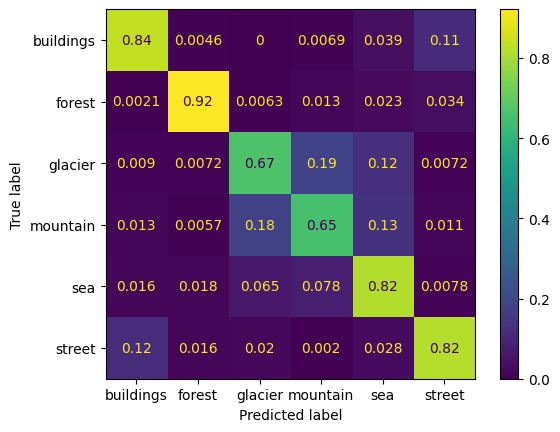

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test_labels, y_pred_labels, normalize="true")
plt.show()